In [1]:
# Install or import the required packages.
import os
import torch
torch.manual_seed(12345)
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Helper function for visualization.
%matplotlib inline
import networkx as nx
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cpu


## Download the Cora dataset

dataset : https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid

In [2]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures()) # normalize the bag-of-words features

## Inspect the Cora graph properties

In [3]:
# Let's look into the basic properties of this graph dataset

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print('\n')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [4]:
print(data.x.shape) # [No. Nodes x Features]

# Features are nothing but bag-of-words vector in normalized form
data.x[0][:200] # lets look into the first data point's vectors first 200 values

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
# As this is node level prediction so for each node we will have a target with values of one of the 7 classes present
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [6]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [7]:
data.edge_index.t() # looking at the edge connections

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

## GNN Network creation for Node Classification

GCN : https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv

SHAPES:
* input: node features , edge indices , edge weights  (optional)
* output: node features 

GCN --> relu --> dropout --> GCN --> relu --> dropout --> linear layer --> log softmax

In [8]:
from torch_geometric.nn import GCNConv #GATConv


class GNN(torch.nn.Module):
    
    def __init__(self , hidden_dim):
        super(GNN,self).__init__()
        
        # initilialize the layers
        self.gcn1 = GCNConv(dataset.num_features , hidden_dim)
        self.gcn2 = GCNConv(hidden_dim , hidden_dim)
        
        self.out = torch.nn.Linear(hidden_dim , dataset.num_classes)
        
    def forward(self, x , edge_index):
        
        # first message passing layer
        x = self.gcn1( x , edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5)
        
        # second message passing layer
        x = self.gcn2(x , edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.4)
        
        # Output layer 
        x = F.log_softmax(self.out(x), dim=1)
        return x

In [9]:
# instantiate the model

hidden_dim = 16
model = GNN(hidden_dim)
print(model)

GNN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [10]:
# Check device availability and move the model and data to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)

# Define loss function 
criterion = torch.nn.NLLLoss()

## Model training and evaluation

In [11]:
def train(model , model_type):
      model.train()
      optimizer.zero_grad()
      if model_type == 'GNN':
          # Use all data as input, because all nodes have node features
          out = model(data.x, data.edge_index)
      else:
          out = model(data.x)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test(model, model_type):
      model.eval()
      if model_type == 'GNN':
          # Use all data as input, because all nodes have node features
          out = model(data.x, data.edge_index)
      else:
          out = model(data.x)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
for epoch in range(0, 2001):
    loss = train(model , 'GNN')
    losses.append(loss.item())
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9588
Epoch: 100, Loss: 0.4726
Epoch: 200, Loss: 0.4499
Epoch: 300, Loss: 0.2797
Epoch: 400, Loss: 0.3323
Epoch: 500, Loss: 0.2550
Epoch: 600, Loss: 0.3362
Epoch: 700, Loss: 0.2484
Epoch: 800, Loss: 0.2404
Epoch: 900, Loss: 0.2938
Epoch: 1000, Loss: 0.2564
Epoch: 1100, Loss: 0.2294
Epoch: 1200, Loss: 0.2100
Epoch: 1300, Loss: 0.1860
Epoch: 1400, Loss: 0.1731
Epoch: 1500, Loss: 0.1965
Epoch: 1600, Loss: 0.1806
Epoch: 1700, Loss: 0.1851
Epoch: 1800, Loss: 0.3132
Epoch: 1900, Loss: 0.1565
Epoch: 2000, Loss: 0.1725


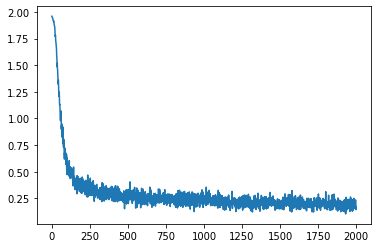

In [12]:
plt.plot(losses)

In [13]:
test_acc = test(model , 'GNN')
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6580


## Checking the performence with Multilayer perceptron

In [14]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5)
        x = F.log_softmax(self.lin2(x))
        return x

model_mlp = MLP(hidden_channels=16)
print(model_mlp)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [15]:
losses = []
for epoch in range(0, 2001):
    loss = train(model_mlp , 'MLP')
    losses.append(loss.item())
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9493
Epoch: 100, Loss: 1.9513
Epoch: 200, Loss: 1.9508
Epoch: 300, Loss: 1.9501
Epoch: 400, Loss: 1.9516
Epoch: 500, Loss: 1.9520
Epoch: 600, Loss: 1.9493
Epoch: 700, Loss: 1.9517
Epoch: 800, Loss: 1.9503
Epoch: 900, Loss: 1.9496
Epoch: 1000, Loss: 1.9504
Epoch: 1100, Loss: 1.9512
Epoch: 1200, Loss: 1.9502
Epoch: 1300, Loss: 1.9498
Epoch: 1400, Loss: 1.9508
Epoch: 1500, Loss: 1.9502
Epoch: 1600, Loss: 1.9502
Epoch: 1700, Loss: 1.9501
Epoch: 1800, Loss: 1.9507
Epoch: 1900, Loss: 1.9510
Epoch: 2000, Loss: 1.9500


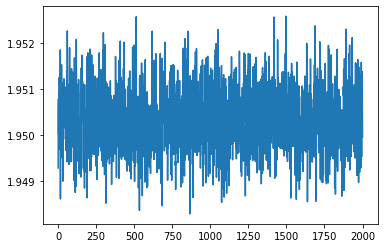

In [16]:
plt.plot(losses)

In [17]:
test_acc = test(model_mlp , 'MLP')
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.0640


We easily see that GNN layer is outperforming the Multilayer perceptron.